# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import numpy as np
import sys,os
import matplotlib.pyplot as plt

# from torch
import torch
from torch import nn
from torch.optim import lr_scheduler

# from torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

# from course lib
import lib.pytorch_trainer_v2 as ptt

In [2]:
from lib import pytorch_trainer_v2 as ptt
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cpu


## Leitura e normalização do dataset MNIST

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
datasets = {
    'train': MNIST(dataset_dir, train=True, transform=data_transform, download=False),
    'val'  : MNIST(dataset_dir, train=False,transform=data_transform),
}

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))

Amostras para treinamento: 60000
Amostras para validação: 10000


## Pequena amostra, apenas para testar o código

In [4]:
if True:
    n_samples_train = 2000
    n_samples_test  = 2000

    datasets['train'].train_data = datasets['train'].train_data[:n_samples_train]
    datasets['train'].train_labels = datasets['train'].train_labels[:n_samples_train]
    datasets['val'].test_data = datasets['val'].test_data[:n_samples_test]
    datasets['val'].test_labels = datasets['val'].test_labels[:n_samples_test]
    
print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))

Amostras para treinamento: 2000
Amostras para validação: 2000


## Cria o DataLoader para os dados

In [5]:
dataloaders = {'train': torch.utils.data.DataLoader(datasets['train'], 
                                                    batch_size=100,
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(datasets['val'], 
                                                    batch_size=100,
                                                    shuffle=False, num_workers=4),}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:', dataset_sizes['val'])

Tamanho do conjunto de treinamento: 2000
Tamanho do conjunto de validacao: 2000


## Mostrando as imagens de um mini-batch do conjunto de treinamento

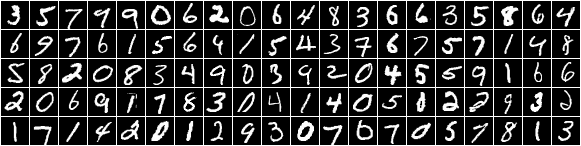

In [6]:
# pega um batch de imagens
image_batch, labels = next(iter(dataloaders['train']))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, nrow=20, padding=1, pad_value=1.0)

tensor2PIL = transforms.ToPILImage()
tensor2PIL(grid)

## Criação do modelo da rede

<img src = '../figures/Rede_LeNet_like.png' width='600pt'></img>

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(
            # lembrar de usar zero padding para manter o tamanho da imagem
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2),   
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout(p=0.5)
        )
        
        # Camadas densas
        self.dense_layer = nn.Sequential(
            nn.Linear(in_features=2450, out_features=80),
            nn.ReLU(),
            nn.Linear(in_features=80, out_features=10),
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 2450)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

## Como encontrar o tamanho correto para entrada da camada densa?

Para encontrar o tamanho da camada densa, criamos uma `Variable` de input com zeros e as mesmas dimensões da imagem de entrada, então a passamos pela camada convolucional. Verificamos a dimensão da saída e o tamanho do vetor após passar por uma vetorização. Este tamanho é o tamanho que deveremos utilizar na entrada da camada densa.

In [8]:
model = MyModel().to(device)

# input do mesmo tamanho que as imagens usadas
example_input = torch.zeros(1, 1, 28, 28).to(device)

# output da camada convolucional
example_output = model.conv_layer(example_input)

print('Dimensões da saída convolucional:', example_output.size())
print('Dimensão após a vetorização:', example_output.view(1, -1).size())

Dimensões da saída convolucional: torch.Size([1, 50, 7, 7])
Dimensão após a vetorização: torch.Size([1, 2450])


## Cria o trainer para o treinamento

In [12]:
model = MyModel().to(device)
    
# Calcula o erro pela CrossEntropy
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters())

trainer = ptt.DeepNetTrainer(
    model=model, 
    criterion   = criterion, 
    optimizer   = optimizer,
    # Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
    lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    callbacks   = [ptt.AccuracyMetric(),
                   ptt.PrintCallback(),
                   ptt.ModelCheckpoint('../../models/lenet-mnist', reset=True, verbose=1)
                  ],
    devname     = device
)

## Treinamento

In [13]:
retrain = True
if retrain:
    trainer.fit_loader(n_epochs=10, train_data=dataloaders['train'], valid_data=dataloaders['val'])
else:
    trainer.load_state('/data/models/lenet-mnist')

Start training for 10 epochs
  1:   8.2s   T: 0.01886 *  0.44500 *   V: 0.01219 *  0.65600 *  
  2:   6.6s   T: 0.00707 *  0.77950     V: 0.00650 *  0.79950    
  3:   7.0s   T: 0.00428 *  0.86750     V: 0.00496 *  0.84450    
  4:   7.4s   T: 0.00315 *  0.90750     V: 0.00428 *  0.86650    
  5:   6.0s   T: 0.00251 *  0.92600     V: 0.00372 *  0.88050    
  6:   5.7s   T: 0.00211 *  0.94000     V: 0.00343 *  0.89250    
  7:   7.2s   T: 0.00176 *  0.94450     V: 0.00279 *  0.91350    
  8:   7.1s   T: 0.00141 *  0.95950     V: 0.00262 *  0.91350    
  9:   5.7s   T: 0.00128 *  0.96400     V: 0.00250 *  0.91900    
 10:   5.6s   T: 0.00127 *  0.96550     V: 0.00256    0.91850    
Stop training at epoch: 10/10
Best model was saved at epoch 9 with loss 0.00250: ../../models/lenet-mnist


Resultado de processamento GPU 1080 treinando com 60000 amostras:

    Start training for 50 epochs

      1:   2.2s   T: 0.23243 0.92832   V: 0.05338 0.98190 best
      2:   2.2s   T: 0.07616 0.97628   V: 0.03680 0.98880 best
      3:   2.2s   T: 0.05656 0.98222   V: 0.03183 0.98860 best
      4:   2.2s   T: 0.04709 0.98510   V: 0.02976 0.99010 best
      5:   2.2s   T: 0.03851 0.98733   V: 0.02714 0.99100 best
      6:   2.2s   T: 0.03338 0.98948   V: 0.02377 0.99200 best
      7:   2.2s   T: 0.02270 0.99252   V: 0.01976 0.99370 best
      8:   2.2s   T: 0.02040 0.99358   V: 0.01904 0.99380 best
      9:   2.2s   T: 0.01935 0.99405   V: 0.01829 0.99390 best
     10:   2.2s   T: 0.01788 0.99430   V: 0.01884 0.99340 
     11:   2.2s   T: 0.01673 0.99460   V: 0.01874 0.99350 
     12:   2.2s   T: 0.01658 0.99488   V: 0.01782 0.99420 best
     13:   2.2s   T: 0.01514 0.99517   V: 0.01735 0.99420 best
     14:   2.2s   T: 0.01480 0.99505   V: 0.01752 0.99400 
     15:   2.2s   T: 0.01472 0.99522   V: 0.01740 0.99410 
     16:   2.2s   T: 0.01374 0.99573   V: 0.01744 0.99400 
     17:   2.2s   T: 0.01433 0.99538   V: 0.01742 0.99400 
     18:   2.2s   T: 0.01379 0.99547   V: 0.01751 0.99420 
     19:   2.2s   T: 0.01402 0.99545   V: 0.01738 0.99390 
     20:   2.2s   T: 0.01425 0.99532   V: 0.01732 0.99390 best

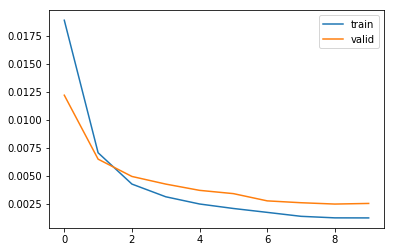

In [14]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt_train = plt.plot(epochs, train_loss, label='train')
plt_valid = plt.plot(epochs, valid_loss, label='valid')
plt.legend()
plt.show()

## Avaliação do treinamento no conjunto de testes

In [15]:
# testa a rede e pega as classes e probabilidades de saída
probs_all = trainer.predict_probas_loader(dataloaders['val'])
y_prob, y_hat = [a.numpy() for a in torch.max(probs_all, dim=1)]

In [16]:
X_test = datasets['val'].test_data.numpy()
y_test = datasets['val'].test_labels.numpy()
print('Rótulos conj. teste:',y_test[:10])
print('Rótulos previstos:  ',y_hat[:10])

Rótulos conj. teste: [7 2 1 0 4 1 4 9 5 9]
Rótulos previstos:   [7 2 1 0 4 1 4 9 5 9]


## Predições certas com maior probabilidade

In [17]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]


## Predições certas com menor probabilidade

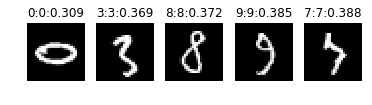

In [18]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_bot5):
    raxis[k].plot(1, 5, k + 1)
    raxis[k].imshow(X_test[i],cmap='gray')
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Predições erradas com maior probabilidade

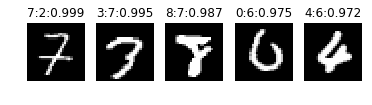

In [19]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_most_not_ok_top5):
    raxis[k].plot(1, 5, k + 1)
    raxis[k].imshow(X_test[i],cmap='gray')
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Predições erradas com menor probabilidade

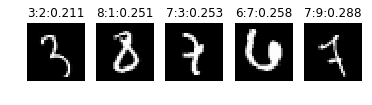

In [20]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]
fig, raxis = plt.subplots(1,5) 
for k,i in enumerate(y_least_not_ok_top5):
    raxis[k].plot(1, 5, k + 1)
    raxis[k].imshow(X_test[i],cmap='gray')
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Atividades

1. Mostre o shape dos parâmetros em cada camada da rede
2. Mostre a matriz de confusão da rede aplicada no conjunto de testes

## Aprendizados com este notebook
1. 